# Rayleigh Block Fading Channel

In [37]:
import numpy as np
import pickle
from itertools import cycle, product
import dill

import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [38]:
blkSize     = 8
chDim       = 4

# Input
inVecDim   = 2 ** blkSize  # 1-hot vector length for block
encDim = 2*chDim

SNR_range_dB = np.arange( 0.0, 40.1, 2.0 )

Channel Utility Functions

In [39]:
def rbf_channel(txBlk, n0):
    N, dim = txBlk.shape
    
    p1 = txBlk[:,:]
    p2 = np.hstack((-txBlk[:,dim//2:],txBlk[:,:dim//2]))
    
    h1 = np.sqrt(1.0/encDim) * np.random.randn(N)
    h2 = np.sqrt(1.0/encDim) * np.random.randn(N)
    
    outBlk = h1[:,None]*p1 + h2[:,None]*p2 + np.random.normal(scale=np.sqrt(n0), size=txBlk.shape)
    
    return outBlk, h1, h2

In [40]:
def rbf_channel_nonoise(txBlk):
    N, dim = txBlk.shape
    
    p1 = txBlk[:,:]
    p2 = np.hstack((-txBlk[:,dim//2:],txBlk[:,:dim//2]))
    
    h1 = np.sqrt(1.0/encDim) * np.random.randn(N)
    h2 = np.sqrt(1.0/encDim) * np.random.randn(N)
    
    outBlk = h1[:,None]*p1 + h2[:,None]*p2
    
    return outBlk, h1, h2

In [41]:
def add_pilot(txBlk, pilotSym):
#     pilotSym = [+1.0, +1.0]
    blkWithPilot = np.insert(txBlk, [0,chDim], values=pilotSym, axis=1)
    
    return blkWithPilot

In [42]:
def equalizer(rxBlk, pilotSym):
#     pilotSym = [+1.0, +1.0]
    
    N, dim = rxBlk.shape
#     print("eq>> rxBlk =", rxBlk)
    
    p1 = rxBlk[:,:]
    p2 = np.hstack((-rxBlk[:,dim//2:],rxBlk[:,:dim//2]))
    
    rxPilots = rxBlk[:,[0,1+chDim]]
    
    h1_hat = (pilotSym[1]*rxPilots[:,1]+pilotSym[0]*rxPilots[:,0])/(pilotSym[1]**2+pilotSym[0]**2)
    h2_hat = (pilotSym[0]*rxPilots[:,1]-pilotSym[1]*rxPilots[:,0])/(pilotSym[1]**2+pilotSym[0]**2)
    
#     print( "eq>> h1_hat:", h1_hat)
#     print( "eq>> h2_hat:", h2_hat)
    
    
    z1_hat = rxBlk[:,:dim//2]
    z2_hat = rxBlk[:,dim//2:]
    
#     print("eq>> z1_hat =", z1_hat)
#     print("eq>> z2_hat =", z2_hat)
    
    
#     print(h1_hat.shape, h2_hat.shape, z1_hat.shape, z2_hat.shape)
    
    zR = (h1_hat[:,None]*z1_hat+h2_hat[:,None]*z2_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
    zI = (h1_hat[:,None]*z2_hat-h2_hat[:,None]*z1_hat) / (h1_hat[:,None]**2+h2_hat[:,None]**2)
    
#     print("eq>>zR =", zR)
#     print("eq>>zI =", zI)
    
    outBlk = np.hstack((zR[:,1:],zI[:,1:]))
    
    return outBlk, h1_hat, h2_hat

To store results

In [43]:
results = {}

## Traditional Systems

### QAM

Generate QAM Map

The pilots we are using are of energy 2 or energy 1 per component. So qam symbol should also have (on an average $1$ as symbol power per component OR $blkSize$ as symbol power over the block.

In [44]:
qam_map = np.array(list(map(list, product([-1.0, +1.0], repeat=blkSize))))
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "QAM Avg. Tx Power:", qam_sym_pow )

qam_map = np.sqrt(blkSize/qam_sym_pow) * qam_map
# qam_map = np.sqrt(1.0/qam_sym_pow) * qam_map
qam_sym_pow = np.mean(np.sum(qam_map*qam_map,axis=1))
print( "Normalized QAM Avg. Tx Power:", qam_sym_pow )

# calculate the pilot symbol
qam_pilotSym = np.sqrt(qam_sym_pow/encDim) * np.ones(2)
# qam_pilotSym =  np.ones(2)

noisePower = qam_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim+2)

QAM Avg. Tx Power: 8.0
Normalized QAM Avg. Tx Power: 8.0


In [45]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0
  while thisErr < 500 and thisCount < 5000000:
    txSym = np.random.randint(inVecDim, size=1000)
    symBlk = qam_map[txSym]
    txTest = add_pilot(symBlk, qam_pilotSym)
    rxTest, _, _ = rbf_channel(txTest, n0)
    rxEqualized, _, _ = equalizer(rxTest, qam_pilotSym)
    rxDecode = cdist(rxEqualized, qam_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)
results["QAM".format(qam_sym_pow)] = np.array(err)

### Agrell

In [46]:
agrell_map = []
if blkSize==2 and chDim==1:
    agrell_map = np.array([
        [ -1.0, -1.0 ],
        [ -1.0, 1.0 ],
        [ 1.0, -1.0 ],
        [ 1.0, 1.0 ]
    ])
elif blkSize==4 and chDim==2:
    agrell_map = np.array([
        [2.148934030042627, 0.0, 0.0, 0.0],
        [0.7347204676695321, 1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, -1.4142135623730951, 0.0, 0.0],
        [0.7347204676695321, 0.0, 1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, -1.4142135623730951, 0.0],
        [0.7347204676695321, 0.0, 0.0, 1.4142135623730951],
        [0.7347204676695321, 0.0, 0.0, -1.4142135623730951],
        [-0.6174729817844246, 1.0, 1.0, 1.0],
        [-0.6174729817844246, 1.0, 1.0, -1.0],
        [-0.6174729817844246, 1.0, -1.0, 1.0],
        [-0.6174729817844246, 1.0, -1.0, -1.0],
        [-0.6174729817844246, -1.0, 1.0, 1.0],
        [-0.6174729817844246, -1.0, 1.0, -1.0],
        [-0.6174729817844246, -1.0, -1.0, 1.0],
        [-0.6174729817844246, -1.0, -1.0, -1.0],
        [-1.6174729817844242, 0.0, 0.0, 0.0]
    ])
elif blkSize==8 and chDim==4:
    agrell_map = np.array([
        [ -256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ -128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 0.0, -256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, -256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, -248.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -264.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -264.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, -242.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, -8.0, 270.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, -8.0, 248.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, -245.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, -242.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 8.0, 248.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 0.0, 264.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 0.0, 256.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, -120.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, -128.0, 136.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, -136.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -370.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -373.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, -117.0, 373.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, -120.0, 120.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, -136.0, 142.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, -136.0, 120.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, -114.0, 139.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, -136.0, 142.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, -117.0, 117.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, -114.0, 139.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, -117.0, -139.0 ],
        [ 128.0, 128.0, 136.0, 120.0, 120.0, 142.0, 139.0, 117.0 ],
        [ 256.0, -256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, -248.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -264.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -264.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, -242.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, -245.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, -267.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 11.0, 245.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 14.0, 267.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, -8.0, 270.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, -8.0, 248.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 8.0, 248.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 0.0, 264.0, -8.0, -8.0, 14.0, 11.0, -11.0 ],
        [ 256.0, 256.0, 8.0, -8.0, -8.0, 14.0, 11.0, -11.0 ] ])
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Agrell Avg. Tx Power:", agrell_sym_pow )

agrell_map = np.sqrt(blkSize/agrell_sym_pow) * agrell_map
# agrell_map = np.sqrt(1.0/agrell_sym_pow) * agrell_map
agrell_sym_pow = np.mean(np.sum(agrell_map*agrell_map,axis=1))
print( "Normalized Agrell Avg. Tx Power:", agrell_sym_pow )

# calculate the pilot symbol
agrell_pilotSym = np.sqrt(agrell_sym_pow/encDim) * np.ones(2)
# agrell_pilotSym = 10.0*np.ones(2)

noisePower = agrell_sym_pow * 10.0**(-SNR_range_dB/10.0)
n0_per_comp = noisePower/(2*chDim+2)
# print("Agrell n0 =", n0_per_comp)

Agrell Avg. Tx Power: 137610.0
Normalized Agrell Avg. Tx Power: 7.999999999999997


In [47]:
err = []
for n0 in n0_per_comp:
  thisErr = 0
  thisCount = 0
  while thisErr < 500 and thisCount < 5000000:
    txSym = np.random.randint(inVecDim, size=1000)
    symBlk = agrell_map[txSym]
    txTest = add_pilot(symBlk, agrell_pilotSym)
    rxTest, _, _ = rbf_channel(txTest, n0)
    rxEqualized, _, _ = equalizer(rxTest, agrell_pilotSym)
    rxDecode = cdist(rxEqualized, agrell_map)
    rxSym = np.argmin(rxDecode,axis=1)
    thisErr += np.sum(rxSym!=txSym)
    thisCount += 1000
  err.append(thisErr/thisCount)
results["[19]"] = np.array(err)

### Plot Results

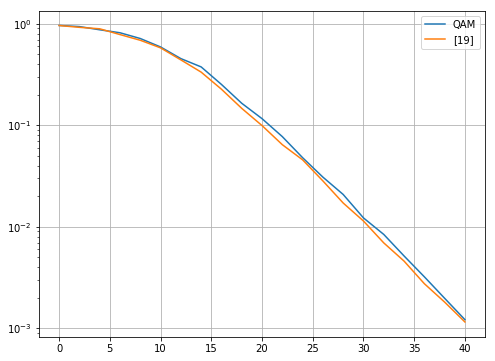

In [48]:
fig = plt.figure(figsize=(8,6))
for (l,v) in results.items():
    plt.semilogy(SNR_range_dB, v, label=l)
plt.legend()
plt.grid()

## Deep Learning Models

List of model summaries to plot

In [49]:
model_summary = {}

# if blkSize==8 and chDim==4:
#     model_summary = { 
#         "AWGN ($\sigma_n^2=0.4$)": "./models_08x04/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN ($\sigma_n^2=0.8$)": "./models_08x04/rbf_awgn_64_32_16_n080_summary.dil",
#         "AWGN ($\sigma_n^2=1.2$)": "./models_08x04/rbf_awgn_64_32_16_n120_summary.dil",
#         "RBF ($\sigma_n^2=0.4$)": "./models_08x04/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF ($\sigma_n^2=0.8$)": "./models_08x04/rbf_rbf_64_32_16_n080_summary.dil",
#         "RBF ($\sigma_n^2=1.2$)": "./models_08x04/rbf_rbf_64_32_16_n120_summary.dil",
#         "Oshea ($4dB$)": "./models_08x04/rbf_oshea_64_32_16_04dB_summary.dil",
#         "Oshea ($10dB$)": "./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil"
#     }
# elif blkSize==4 and chDim==2:
#     model_summary = {
#         "AWGN($\sigma_n^2=0.2$)": "./models_04x02/rbf_awgn_64_32_16_n020_summary.dil",
#         "AWGN($\sigma_n^2=0.4$)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN($\sigma_n^2=0.6$)": "./models_04x02/rbf_awgn_64_32_16_n060_summary.dil",
#         "RBF($\sigma_n^2=0.2$)": "./models_04x02/rbf_rbf_64_32_16_n020_summary.dil",
#         "RBF($\sigma_n^2=0.4$)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF($\sigma_n^2=0.6$)": "./models_04x02/rbf_rbf_64_32_16_n060_summary.dil",
#         "Oshea ($4dB$)": "./models_04x02/rbf_oshea_64_32_16_04dB_summary.dil",
#         "Oshea ($10dB$)": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.dil"
#     }
# elif blkSize==2 and chDim==1:
#     model_summary = {
        
#     }
# else:
#     raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

if blkSize==8 and chDim==4:
    model_summary = { 
        "[1]": "./models_08x04/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN ($\sigma_n^2=0.4$)": "./models_08x04/rbf_awgn_64_32_16_n040_summary.dil",
        "Proposed: Trained with (19)": "./models_08x04/rbf_awgn_64_32_16_n080_summary.dil",
#         "AWGN ($\sigma_n^2=1.2$)": "./models_08x04/rbf_awgn_64_32_16_n120_summary.dil",
#         "RBF ($\sigma_n^2=0.4$)": "./models_08x04/rbf_rbf_64_32_16_n040_summary.dil",
        "Proposed: Trained with (23)": "./models_08x04/rbf_rbf_64_32_16_n080_summary.dil",
#         "RBF ($\sigma_n^2=1.2$)": "./models_08x04/rbf_rbf_64_32_16_n120_summary.dil",
#         "Oshea ($4dB$)": "./models_08x04/rbf_oshea_64_32_16_04dB_summary.dil",
    }
elif blkSize==4 and chDim==2:
    model_summary = {
        "[1]": "./models_04x02/rbf_oshea_64_32_16_10dB_summary.dil",
#         "AWGN($\sigma_n^2=0.2$)": "./models_04x02/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (19)": "./models_04x02/rbf_awgn_64_32_16_n040_summary.dil",
#         "AWGN($\sigma_n^2=0.6$)": "./models_04x02/rbf_awgn_64_32_16_n060_summary.dil",
#         "RBF($\sigma_n^2=0.2$)": "./models_04x02/rbf_rbf_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_04x02/rbf_rbf_64_32_16_n040_summary.dil",
#         "RBF($\sigma_n^2=0.6$)": "./models_04x02/rbf_rbf_64_32_16_n060_summary.dil",
#         "Oshea ($4dB$)": "./models_04x02/rbf_oshea_64_32_16_04dB_summary.dil",
    }
elif blkSize==2 and chDim==1:
    model_summary = {
        "[1]": "./models_02x01/rbf_oshea_64_32_16_10dB_summary.dil",
        "Proposed: Trained with (19)": "./models_02x01/rbf_awgn_64_32_16_n020_summary.dil",
        "Proposed: Trained with (23)": "./models_02x01/rbf_rbf_64_32_16_n020_summary.dil",
    }
else:
    raise NotImplementedError("Not implemented (blkSize={},chDim={})".format(blkSize,chDim))

In [50]:
const_pow = {}
bler_values = {}
bler_mean = {}
bler_std = {}
bler_metrics = {} # To compare which model is better using L2
bler_bestidx = {}
bler_maxidx = {}

Plot the results for all models

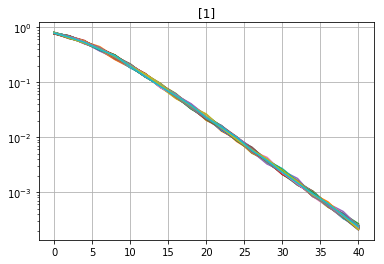

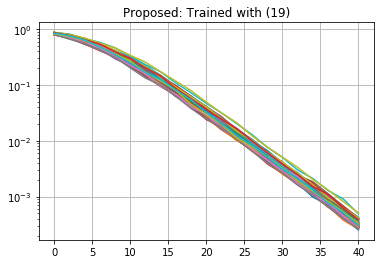

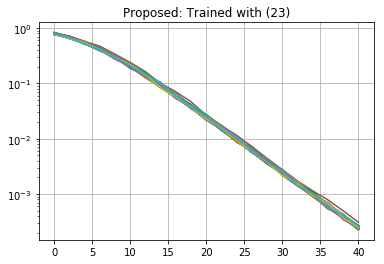

In [51]:
for (model,summary_file) in model_summary.items():
    plt.figure()
    summary_data = {}
#     print(summary_file)
    # Load file
    with open(summary_file, "rb") as file:
        summary_data = dill.load(file)
    # Plot each summary
    for (modelid,(sym_pow,bler)) in summary_data.items():
#         print(bler, len(bler))
#         print(SNR_range_dB, len(SNR_range_dB))
        plt.semilogy(SNR_range_dB, bler)
    plt.title(model)
    plt.grid()
    # Compute metrics
    const_pow[model] = np.array([p for (p,_) in summary_data.values()])
    bler_values[model] = np.array([b for (_,b) in summary_data.values()])
    bler_mean[model] = np.mean(bler_values[model], axis=0)
    bler_std[model] = np.std(bler_values[model], axis=0)
    bler_metrics[model] = np.linalg.norm(bler_values[model], axis=1)
    bler_bestidx[model] = np.argmin(bler_metrics[model])
    bler_maxidx[model] = np.argmax(bler_metrics[model])

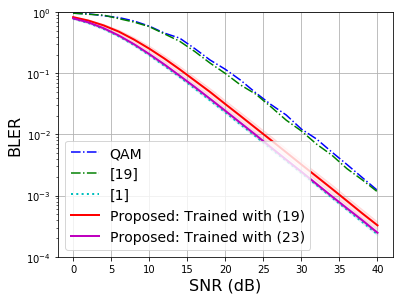

In [52]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
plt.figure(figsize=(4*1.5,3*1.5))
for (l,bler) in results.items():
    plt.semilogy(SNR_range_dB, bler, label=l, color=next(colors), linestyle="-.")
for model in model_summary.keys():
    clr = next(colors)
    plt.fill_between(SNR_range_dB, bler_mean[model]+bler_std[model], bler_mean[model]-bler_std[model], alpha=0.1, color=clr)
    plt.semilogy(SNR_range_dB, bler_mean[model], label=model, 
                 color=clr, linewidth=2, linestyle=":" if "Oshea" in model or "[1]" in model else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Avg. observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR (dB)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-4,1e0))
plt.savefig("output_rbf_avg_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("output_rbf_avg_bler_{:02d}x{:02d}.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')

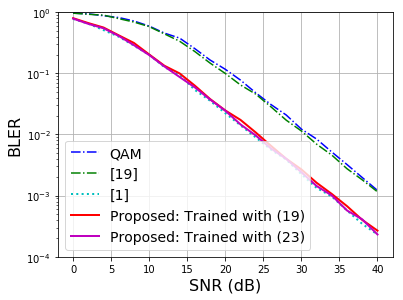

In [53]:
colors = cycle(['b', 'g', 'c', 'r', 'm', 'y'])
plt.figure(figsize=(4*1.5,3*1.5))
for (l,bler) in results.items():
    plt.semilogy(SNR_range_dB, bler, label=l, color=next(colors), linestyle="-.")
for model in model_summary.keys():
    clr = next(colors)
    plt.semilogy(SNR_range_dB, bler_values[model][bler_bestidx[model]], 
                 label=model, color=clr, linewidth=2,
                 linestyle=":" if "Oshea" in model or "[1]" in model else "-")
plt.legend(loc="lower left", prop={'size':14})
plt.grid()
# plt.title("Best observed BLER of trained models", fontdict={'fontsize':18})
plt.xlabel("SNR (dB)", fontdict={'fontsize':16})
plt.ylabel("BLER", fontdict={'fontsize':16})
plt.ylim((1e-4,1e0))
plt.savefig("output_rbf_best_bler_{:02d}x{:02d}.pdf".format(blkSize,chDim), format='pdf', bbox_inches='tight')
plt.savefig("output_rbf_best_bler_{:02d}x{:02d}.eps".format(blkSize,chDim), format='eps', bbox_inches='tight')

No handles with labels found to put in legend.


Text(0.5, 0, 'Train SNR (dB)')

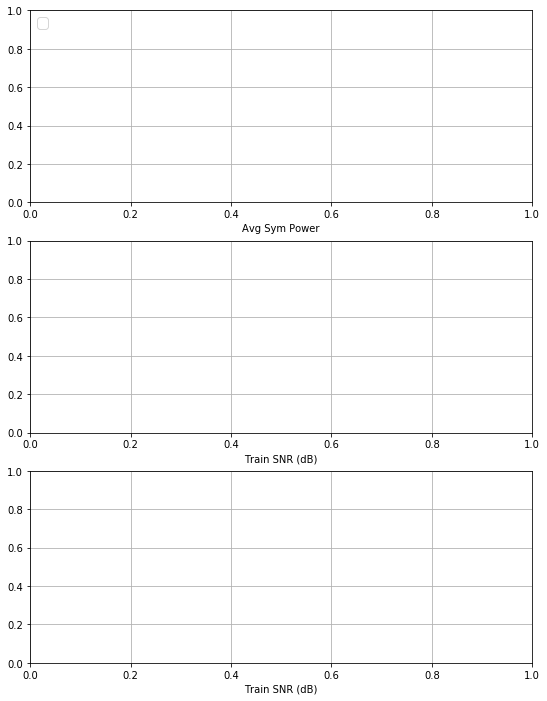

In [54]:
import re
colors = cycle(['b', 'g', 'r', 'c', 'm', 'y'])
fig, ax = plt.subplots(3, figsize=(9,12))
for (model,txpow) in const_pow.items():
    clr = next(colors)
    if "\sigma_n^2" in model:  # Other models are trained at constant SNR, so have dB in their label
        n0 = float(re.findall("\d+\.\d+",model)[0])
        train_snr = 10.0 * np.log10(txpow/n0)
        ax[0].hist( txpow, label=model, color=clr, bins=10 )
        ax[1].hist( train_snr, label=model, color=clr, bins=10 )
        ax[2].hist( train_snr, label=model, color=clr, bins=100, cumulative=True, histtype="step")
ax[0].legend(loc="upper left", prop={'size':14})
for _ax in ax:
    _ax.grid()
ax[0].set_xlabel("Avg Sym Power")
ax[1].set_xlabel("Train SNR (dB)")
ax[2].set_xlabel("Train SNR (dB)")